Universidad Torcuato Di Tella

Metodos computacionales\
**Trabajo Práctico 1:
Resoluciones Numéricas de Ecuaciones Diferenciales**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def condicion_inicial(x):
    if 0 <= x and x < 0.25:
        return 4.0*x
    elif 0.25 <= x and x < 0.50:
        return -2.0*x + 1.5
    elif 0.50 <= x and x < 0.75:
        return 2.0*x - 0.5
    elif 0.75 <= x and x <= 1.00:
        return -4.0*x + 4.0
    else:
        print("x tiene que tenr un valor entre 0 y 1")
                       


def e_c_metodoexplicito(alpha, funcion, dx, dt, T):
    N  = int(round(1.0/dx))
    M = int(round(T/dt))
    x = np.arange(0, 1+dx, dx, dtype = float)
    t = np.arange(0, T+dt, dt, dtype = float)
    matriz_u = np.zeros((M+1, N+1), dtype = float)
    r  = alpha * dt / (dx**2)
    y = np.zeros(N+1)
    for pos in range(N+1):
        y[pos] =funcion(x[pos]) 
    matriz_u[0, :] = y # la primero fila se llena con la condicion inicial
    A = np.zeros((N-1, N-1))
    for a in range(N-1):
        A[a, a] = 1 - 2*r
        if a > 0:
            A[a, a-1] = r
        if a < N-2:
            A[a, a+1] = r

    for n in range(M): #las filas 
        x_vec = matriz_u[n, 1:N] #b es la fila i seleccionando todos los elementos excepto el primer elmento  y el ultimo por las condiciones de borde 
        b = A.dot(x_vec) 
        matriz_u[n+1, 1:N] = b
    return matriz_u, x, t, y

def e_c_metodoimplicito(alpha, funcion, dx, dt, T):
    N  = int(round(1.0/dx))
    M = int(round(T/dt))
    x = np.arange(0, 1+dx, dx, dtype = float)
    t = np.arange(0, T+dt, dt, dtype = float)
    matriz_u = np.zeros((M+1, N+1), dtype = float)
    r  = alpha * dt / (dx**2)
    y = np.zeros(N+1)
    for pos in range(N+1):
        y[pos] =funcion(x[pos]) 
    matriz_u[0, :] = y # la primero fila se llena con la condicion inicial
    A = np.zeros((N-1, N-1))
    for a in range(N-1):
        A[a, a] = 1 + 2*r
        if a > 0:
            A[a, a-1] = -r
        if a < N-2:
            A[a, a+1] = -r

    for n in range(M):
        b = matriz_u[n, 1:N] #b es la fila i seleccionando todos los elementos excepto el primer elmento  y el ultimo por las condiciones de borde 

        u_interior = np.linalg.solve(A, b) #resuelve la ecuacion lineal 
        matriz_u[n+1, 1:N] = u_interior

    return matriz_u, x, t,y

In [ ]:
alpha = 1.0
dx    = 0.05
dt    = 0.001
T     = 0.1

U_e, x_e, t_e, y_e = e_c_metodoexplicito(alpha, condicion_inicial, dx, dt, T)
U_i, x_i, t_i, y_i= e_c_metodoimplicito(alpha, condicion_inicial, dx, dt, T)


In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

def crear_gif(alpha, funcion, dx, dt, T, nombre_gif):
    u_ex, x_e, t_e, y_e = e_c_metodoexplicito(alpha, funcion, dx, dt, T)
    u_im, x_i, t_i, y_i= e_c_metodoimplicito(alpha, funcion, dx, dt, T)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    # Líneas iniciales
    line_ex, = ax1.plot(x_e, u_ex[0, :], color='blue')
    ax1.set_title("Método Explícito")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1.1*np.max(u_ex))
    ax1.set_xlabel("x")
    ax1.set_ylabel("u(x,t)")
    ax1.grid(True)

    line_im, = ax2.plot(x_i, u_im[0, :], color='red')
    ax2.set_title("Método Implícito")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1.1*np.max(u_ex))
    ax2.set_xlabel("x")
    ax2.set_ylabel("u(x,t)")
    ax2.grid(True)

    # Función que actualiza cada frame
    def actualizar(frame):
        line_ex.set_ydata(u_ex[frame, :])
        ax1.set_title(f"Método Explícito t={t_e[frame]:.3f}")
        line_im.set_ydata(u_im[frame, :])
        ax2.set_title(f"Método Implícito t={t_i[frame]:.3f}")
        return line_ex, line_im

    anim = FuncAnimation(fig, actualizar, frames=len(t_e), interval=100, blit=True)
    anim.save(nombre_gif, writer=PillowWriter(fps=5))
    print(f"GIF guardado como {nombre_gif}")



GIF guardado como metodo_ex_vs_im.gif


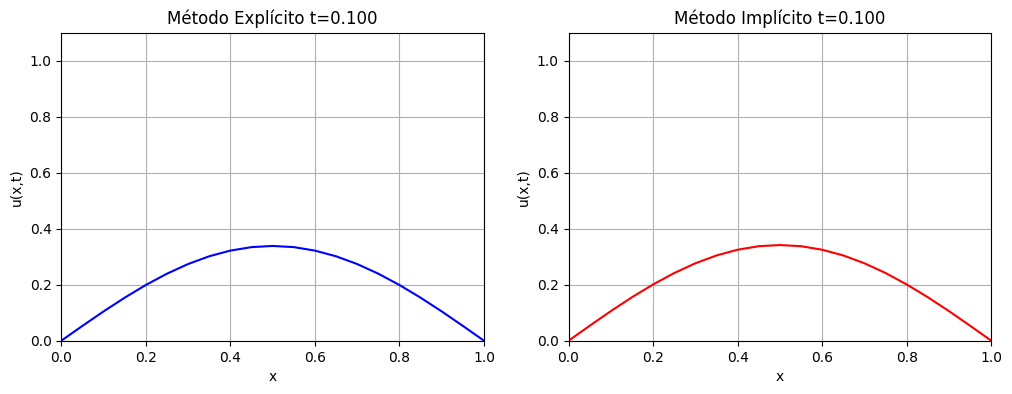

In [123]:
crear_gif(alpha, condicion_inicial, dx, dt, T, "metodo_ex_vs_im.gif")


In [124]:
x_e

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [125]:
U_e[5, :]


array([0.      , 0.196928, 0.386176, 0.552384, 0.684032, 0.76096 ,
       0.78608 , 0.7616  , 0.71792 , 0.67424 , 0.65936 , 0.67424 ,
       0.71792 , 0.7616  , 0.78608 , 0.76096 , 0.684032, 0.552384,
       0.386176, 0.196928, 0.      ])

In [126]:
U_i[5, :]

array([0.        , 0.19355404, 0.38096998, 0.55247076, 0.69168164,
       0.77716405, 0.79593322, 0.7650001 , 0.71216983, 0.66431714,
       0.64438825, 0.66431714, 0.71216983, 0.7650001 , 0.79593322,
       0.77716405, 0.69168164, 0.55247076, 0.38096998, 0.19355404,
       0.        ])